In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_dataset = datasets.MNIST(root="./data",train=True, download=True, transform=transform)

test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

print(f"Training data ready with {len(train_dataset)} images")

Training data ready with 60000 images


In [12]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(64*7*7, 128)

        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Reshape 3D feature map to 1D vector
        # output = [Batch, 3136]
        x = x.view(-1, 64*7*7)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

model = SimpleCNN()

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(model, train_loader, epochs):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Loss for step {epoch + 1}: {loss.item():.4f}")

train(model, train_loader=train_loader, epochs=5)

Loss for step 1: 0.2849
Loss for step 2: 0.1820
Loss for step 3: 0.0839
Loss for step 4: 0.1727
Loss for step 5: 0.0306


In [16]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct/total
    print(f"Accuracy of the network on the 10000 test images: {accuracy:.4f}%")

test_model(model, test_loader)

Accuracy of the network on the 10000 test images: 97.8300%


In [18]:
def predict_custom_image(image_path, model):
    img = Image.open(image_path)

    img = img.convert("L")
    img = ImageOps.invert(img)
    img = img.resize((28, 28))
    img_tensor = transform(img)

    # 3. Add Batch Dimension
    # The model expects [Batch, Channel, Height, Width]
    # Current shape is [1, 28, 28]. We need [1, 1, 28, 28].
    img_tensor = img_tensor.unsqueeze(0)

    plt.imshow(img_tensor.squeeze().numpy(), cmap = 'gray')
    plt.title("Processed Input for Model")
    plt.show()

    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        probs = F.softmax(output, dim=1)
        confidence, predicted_class = torch.max(probs, 1)
        print(f"Prediction: {predicted_class.item()}")
        print(f"Confidence: {confidence.item() * 100:.2f}%")

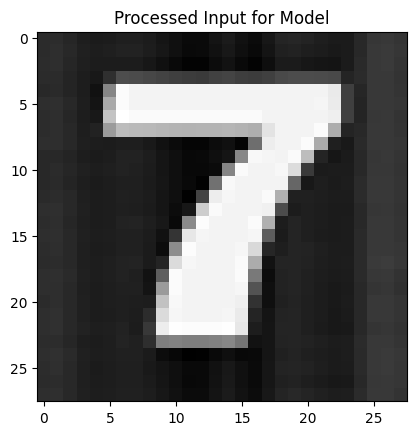

Prediction: 2
Confidence: 64.09%


In [19]:
predict_custom_image("../inputs/seven.png", model)